In [73]:
!git clone https://github.com/Toza-M/movie_data_analysis.git

fatal: destination path 'movie_data_analysis' already exists and is not an empty directory.


In [74]:
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

In [75]:
financial = pd.read_csv("movie_data_analysis/data/movies_financial.csv")
imdb = pd.read_csv("movie_data_analysis/data/imdb_data.csv")

df = financial.merge(imdb, on="Title", how="inner")
df.head()

,Release Date,Title,Budget,Domestic Gross,Worldwide Gross,Year,Rating,Vote Count,Language
0,"Apr 23, 2019",Avengers: Endgame,"$400,000,000","$858,373,000","$2,717,503,922",2019.0,8.237,26987,en
1,"Dec 9, 2022",Avatar: The Way of Water,"$400,000,000","$688,809,501","$2,322,902,023",2022.0,7.610,13128,en
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$379,000,000","$241,071,802","$1,045,713,802",2011.0,6.563,14607,en
3,"Apr 22, 2015",Avengers: Age of Ultron,"$365,000,000","$459,005,868","$1,395,316,979",2015.0,7.271,23894,en
4,"May 17, 2023",Fast X,"$340,000,000","$146,126,015","$714,375,114",2023.0,7.000,6120,en


Question 2:
Do movies released in summer perform better financially than those in winter?

In [76]:
df['Release Date'] = pd.to_datetime(df['Release Date'], format='mixed', errors='coerce')
df['Month'] = df['Release Date'].dt.month

In [77]:
df['Worldwide Gross'] = (
    df['Worldwide Gross']
    .replace(r'[$,]', '', regex=True)
    .astype(float)
)

In [78]:
summer = df[df['Month'].isin([6, 7, 8])]['Worldwide Gross']
winter = df[df['Month'].isin([12, 1, 2])]['Worldwide Gross']

In [79]:
t_stat, p_value = ttest_ind(summer, winter, nan_policy='omit')

summer.mean(), winter.mean(), p_value

(np.float64(198651432.61026353),
 np.float64(149573762.92784992),
 np.float64(0.00030684718158159027))

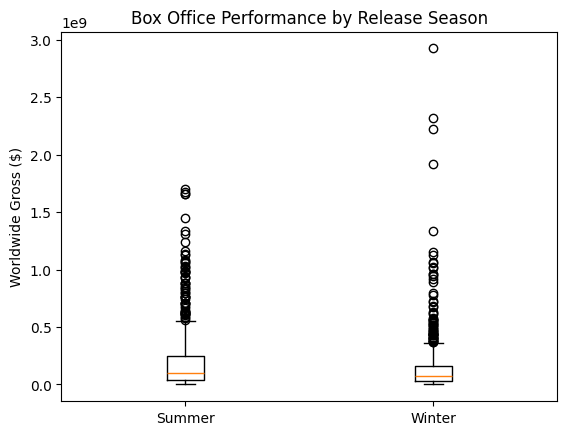

In [80]:
plt.boxplot([summer, winter], tick_labels=['Summer', 'Winter'])
plt.ylabel("Worldwide Gross ($)")
plt.title("Box Office Performance by Release Season")
plt.show()

In [81]:
print(f"Summer mean gross  ≈ ${summer.mean():,.0f}")
print(f"Winter mean gross  ≈ ${winter.mean():,.0f}")
print(f"p-value            ≈ {p_value:.5f}")

Summer mean gross  ≈ $198,651,433
Winter mean gross  ≈ $149,573,763
p-value            ≈ 0.00031


Question 3:
Is there a significant difference between critics’ and audience ratings across genres?


In [82]:
import requests

API_KEY = "6b1c54551e0e2df55b6bdf448af1b9f1"

def get_genres():
    url = f"https://api.themoviedb.org/3/genre/movie/list?api_key={API_KEY}&language=en-US"
    return {g['id']: g['name'] for g in requests.get(url).json()['genres']}

genre_map = get_genres()

In [83]:
def fetch_movie_genres(title):
    search_url = f"https://api.themoviedb.org/3/search/movie?api_key={API_KEY}&query={title}"
    r = requests.get(search_url).json()
    if r['results']:
        return [genre_map[g] for g in r['results'][0]['genre_ids']]
    return []

df['Genres'] = df['Title'].apply(fetch_movie_genres)


In [84]:
df_genres = df.explode('Genres')

In [85]:
genre_ratings = (
    df_genres
    .groupby('Genres')['Rating']
    .mean()
    .sort_values(ascending=False)
)

genre_ratings

,Rating
Genres,
Documentary,7.135500
History,7.131213
War,7.100456
Animation,7.029140
Drama,6.998748
Music,6.971956
Western,6.968692
Family,6.963696
Science Fiction,6.926816


In [86]:
df['Critics_Proxy'] = df['Rating'] * df['Vote Count']
df_genres = df.explode('Genres').dropna(subset=['Genres'])

In [87]:
genre_compare = (
    df_genres
    .groupby('Genres')[['Rating', 'Critics_Proxy']]
    .mean()
    .sort_values(by='Rating', ascending=False)

)
genre_compare

,Rating,Critics_Proxy
Genres,,
Documentary,7.135500,17142.677417
History,7.131213,19781.398417
War,7.100456,27581.866496
Animation,7.029140,41630.124775
Drama,6.998748,24063.807062
Music,6.971956,16457.080667
Western,6.968692,24918.350212
Family,6.963696,35024.911299
Science Fiction,6.926816,53307.135205


In [88]:
from scipy.stats import ttest_rel

t_stat, p_value = ttest_rel(
    genre_compare['Rating'],
    genre_compare['Critics_Proxy']
)

print(f"p-value ≈ {p_value:.5f}")

p-value ≈ 0.00000
